In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

import io

import numpy as np
import cv2

import ollama

from PIL import Image
import subprocess

In [21]:

def get_b_array(image_path):
    with open(image_path, 'rb') as image_file:
        img1 = Image.open(image_file)
        
        # Convert the image to a byte stream in JPEG format
        img_byte_arr = io.BytesIO()
        img1.save(img_byte_arr, format='JPEG')  # or 'PNG' if you prefer
        img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr

In [22]:
def find_webcam_index(device_name):
    command = "v4l2-ctl --list-devices"
    output = subprocess.check_output(command, shell=True, text=True)
    devices = output.split('\n\n')
    
    for device in devices:
        if device_name in device:
            lines = device.split('\n')
            for line in lines:
                if "video" in line:
                    parts = line.split()
                    for part in parts:
                        if part.startswith('/dev/video'):
                            print(part)
                            return (part[10:])

In [23]:
webcam_index = int(find_webcam_index("C922")) #C922 #3D USB
webcam_index


/dev/video0


0

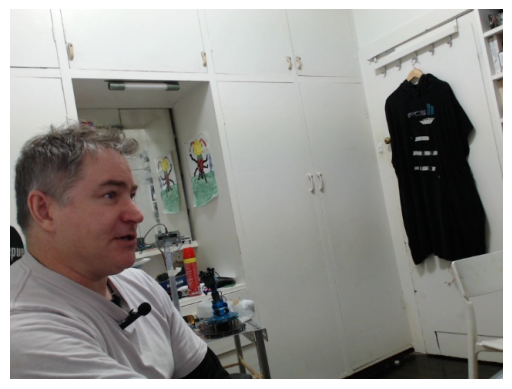

In [24]:
# Set the resolution
width = 640 #320  # Desired width
height = 480 # 240  # Desired height
mult = 1
cap = cv2.VideoCapture(webcam_index)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)

if not cap.isOpened():
    print("Error: Could not open video stream.")
    exit()

while True:
    # Read a frame from the camera
    ret, frame = cap.read()

    # If the frame was read correctly
    if not ret:
        print("Error: Failed to read frame.")
        break

    # Display the frame
    cv2.imshow('Camera Stream', frame)

    # Press 'q' to quit the stream
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.imwrite('frame.jpg', frame)
        break


# Release the capture and close the window
cap.release()
cv2.destroyAllWindows()
img1 = cv2.imread('frame.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.axis('off')  # Hide the axes
plt.show()


In [25]:
bus_img = get_b_array('frame.jpg')

In [26]:
response = ollama.chat(model='llava', messages=[
    {
        'role': 'user',
        'content': 'Extract the objects in the image. Return only a plain list of object names, comma-separated, no other words.',
        #'List only the objects you see in this image. Respond with a simple, comma-separated list with no explanation.',
        'images': [bus_img],
    },
])


In [27]:
# sudo pkill ollama
text = (response['message'])['content']
print("Response:", text)

Response:  man, chair, mirror, cabinet, shirt, tie, jacket, pants, boots, t-shirt, poster, shelf, sink, faucet, bottle, cup, toothbrush, brush, hairdryer, wall, door, floor, cabinet, drawer, table, glass, light, bulb 


In [28]:
import ultralytics
from ultralytics import YOLO
import supervision as sv

In [29]:
# // I need to write file to predict with yolo world.
model = YOLO("yolov8m-world.pt")  # load a pretrained model (recommended for best performance)

s = text
objects = [item.strip() for item in s.split(',')]
model.set_classes(objects) #["vheicle", "person", "road"])  # set custom class names

results=model.predict(source="frame.jpg", save=True, conf=0.005)  # predict on an image with confidence threshold




image 1/1 /home/jonny/projects/yolo_with_llm/frame.jpg: 480x640 1 man, 6 chairs, 1 mirror, 29 cabinets, 2 shirts, 1 jacket, 5 posters, 11 shelfs, 1 faucet, 12 bottles, 1 cup, 3 toothbrushs, 1 brush, 4 hairdryers, 2 walls, 2 doors, 4 floors, 3 tables, 1 light, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict37


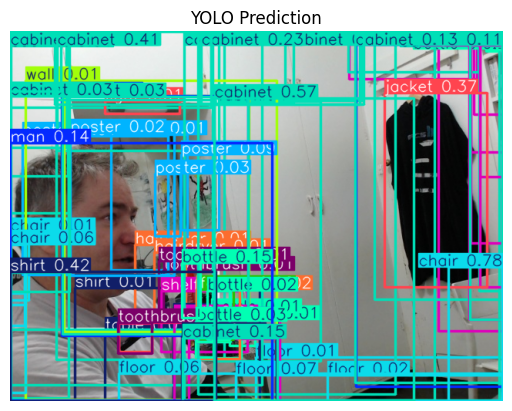

In [30]:
result = results[0]

# Get the annotated image (with bounding boxes)
annotated_img = result.plot()

# OpenCV returns BGR format, convert to RGB for matplotlib
import cv2
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

# Show the image
plt.imshow(annotated_img_rgb)
plt.axis('off')
plt.title("YOLO Prediction")
plt.show()

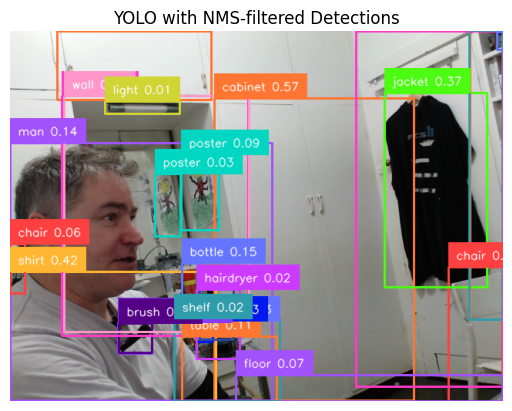

In [31]:
image = cv2.imread("frame.jpg")
detections = sv.Detections.from_ultralytics(result).with_nms(threshold=0.0, class_agnostic=False)
detections = detections[detections.confidence > 0.01]

# Annotate filtered detections
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
labels = [
    f"{result.names[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

annotated_img = box_annotator.annotate(
    scene=image.copy(), detections=detections)
annotated_img = label_annotator.annotate(
    scene=annotated_img, detections=detections, labels=labels)

# annotated_img = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Convert BGR to RGB for matplotlib
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

# Show the image
plt.imshow(annotated_img_rgb)
plt.axis("off")
plt.title("YOLO with NMS-filtered Detections")
plt.show()

In [ ]:

# response = ollama.chat(model='llava', messages=[
#     {
#         'role': 'user',
#         'content': 'Extract the objects in the image. Return only a plain list of object names, comma-separated, no other words.',
#         'images': [bus_img],
#     },
# ])